In [1]:
%matplotlib inline


# Transfer Learning for Computer Vision Tutorial
**Author**: [Sasank Chilamkurthy](https://chsasank.github.io)

In this tutorial, you will learn how to train a convolutional neural network for
image classification using transfer learning. You can read more about the transfer
learning at [cs231n notes](https://cs231n.github.io/transfer-learning/)_

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initialization, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.


In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

## Load Data

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),    
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = 'flower'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Visualize a few images
Let's visualize a few training images so as to understand the data
augmentations.



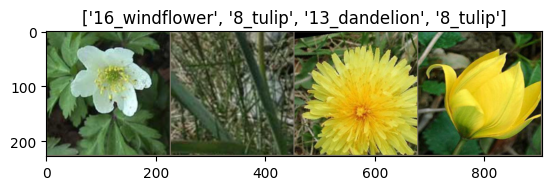

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training the model

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss = []
    val_loss = []
    test_loss = []
    train_acc = []
    val_acc = []
    test_acc = []
    x_epoch = np.arange(num_epochs)
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc.cpu())

            elif phase == 'val':
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc.cpu())
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    fig = plt.figure()
    ax0 = fig.add_subplot(121, title="loss")
    ax1 = fig.add_subplot(122, title="top1acc")

    ax0.plot(x_epoch, train_loss, 'bo-', label = 'train')
    ax0.plot(x_epoch, val_loss, 'ro-', label = 'val')
    ax1.plot(x_epoch, train_acc, 'bo-', label = 'train')
    ax1.plot(x_epoch, val_acc, 'ro-', label = 'val')
    ax0.legend()
    ax1.legend()
    fig.savefig(os.path.join('./lossGraphs', 'train.jpg'))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Visualizing the model predictions

Generic function to display predictions for a few images




In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning the convnet




# lr=0.001 (default)

In [7]:
# model_ft = models.densenet121(pretrained=True)
model_ft = models.densenet121()
num_ftrs = model_ft.classifier.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.classifier = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### Train and evaluate

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




Epoch 0/49
----------
train Loss: 2.4423 Acc: 0.1801
val Loss: 2.2294 Acc: 0.3309
test Loss: 1.9038 Acc: 0.3529

Epoch 1/49
----------
train Loss: 2.0778 Acc: 0.3130
val Loss: 2.1710 Acc: 0.4265
test Loss: 1.9181 Acc: 0.4265

Epoch 2/49
----------
train Loss: 1.9218 Acc: 0.3672
val Loss: 2.4096 Acc: 0.4926
test Loss: 2.1341 Acc: 0.4706

Epoch 3/49
----------
train Loss: 1.8449 Acc: 0.3929
val Loss: 2.3596 Acc: 0.4853
test Loss: 2.2655 Acc: 0.4559

Epoch 4/49
----------
train Loss: 1.7404 Acc: 0.4338
val Loss: 2.3533 Acc: 0.5882
test Loss: 2.0475 Acc: 0.5074

Epoch 5/49
----------
train Loss: 1.6595 Acc: 0.4609
val Loss: 1.8753 Acc: 0.6324
test Loss: 1.7412 Acc: 0.5000

Epoch 6/49
----------
train Loss: 1.6184 Acc: 0.4789
val Loss: 1.8822 Acc: 0.5882
test Loss: 1.8509 Acc: 0.5882

Epoch 7/49
----------
train Loss: 1.4351 Acc: 0.5597
val Loss: 1.2459 Acc: 0.7279
test Loss: 1.4333 Acc: 0.6544

Epoch 8/49
----------
train Loss: 1.3775 Acc: 0.5685
val Loss: 1.6721 Acc: 0.7279
test Loss: 1.4

FileNotFoundError: [Errno 2] No such file or directory: './lossGraphs/train.jpg'

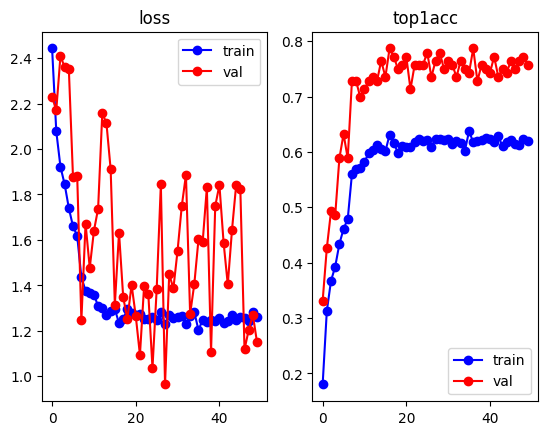

In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50)

# lr=0.01

In [9]:
# model_ft = models.densenet121(pretrained=True)
model_ft = models.densenet121()
num_ftrs = model_ft.classifier.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.classifier = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Epoch 0/49
----------
train Loss: 2.7839 Acc: 0.1558
val Loss: 5.7304 Acc: 0.2941
test Loss: 5.7256 Acc: 0.2721

Epoch 1/49
----------
train Loss: 2.2969 Acc: 0.2509
val Loss: 5.4900 Acc: 0.3015
test Loss: 4.7245 Acc: 0.3235

Epoch 2/49
----------
train Loss: 2.1285 Acc: 0.2978
val Loss: 2.5616 Acc: 0.4559
test Loss: 1.9248 Acc: 0.3824

Epoch 3/49
----------
train Loss: 2.0381 Acc: 0.3254
val Loss: 3.0278 Acc: 0.4044
test Loss: 4.0260 Acc: 0.4044

Epoch 4/49
----------
train Loss: 1.9551 Acc: 0.3520
val Loss: 2.4689 Acc: 0.4265
test Loss: 2.0370 Acc: 0.4265

Epoch 5/49
----------
train Loss: 1.8447 Acc: 0.3971
val Loss: 1.8331 Acc: 0.5588
test Loss: 1.5778 Acc: 0.4926

Epoch 6/49
----------
train Loss: 1.8364 Acc: 0.3938
val Loss: 6.5361 Acc: 0.5294
test Loss: 2.3817 Acc: 0.4779

Epoch 7/49
----------
train Loss: 1.5620 Acc: 0.4789
val Loss: 10.9264 Acc: 0.5294
test Loss: 2.7332 Acc: 0.4926

Epoch 8/49
----------
train Loss: 1.4919 Acc: 0.5193
val Loss: 7.0036 Acc: 0.5809
test Loss: 1.

FileNotFoundError: [Errno 2] No such file or directory: './lossGraphs/train.jpg'

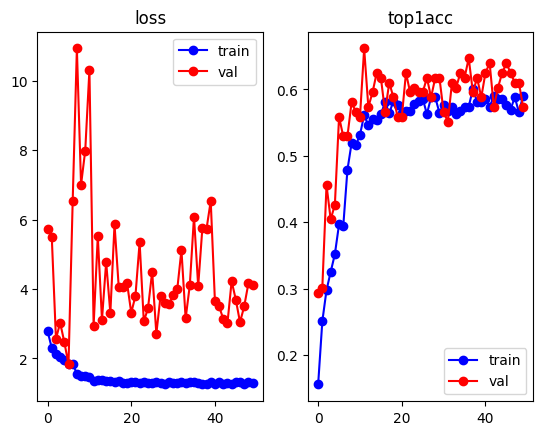

In [10]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50)

# lr=0.0005

In [7]:
# model_ft = models.densenet121(pretrained=True)
model_ft = models.densenet121()
num_ftrs = model_ft.classifier.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.classifier = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft3 = optim.SGD(model_ft.parameters(), lr=0.0005, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft3, step_size=7, gamma=0.1)

Epoch 0/49
----------
train Loss: 2.5412 Acc: 0.1788
val Loss: 2.0455 Acc: 0.3382
test Loss: 1.9904 Acc: 0.3382

Epoch 1/49
----------
train Loss: 2.1753 Acc: 0.3084
val Loss: 2.1593 Acc: 0.4118
test Loss: 2.0095 Acc: 0.3529

Epoch 2/49
----------
train Loss: 2.0054 Acc: 0.3447
val Loss: 1.9689 Acc: 0.4926
test Loss: 1.8222 Acc: 0.5221

Epoch 3/49
----------
train Loss: 1.9114 Acc: 0.3892
val Loss: 1.8270 Acc: 0.4559
test Loss: 1.7668 Acc: 0.4485

Epoch 4/49
----------
train Loss: 1.8185 Acc: 0.4076
val Loss: 1.8966 Acc: 0.5221
test Loss: 1.8456 Acc: 0.4779

Epoch 5/49
----------
train Loss: 1.7667 Acc: 0.4347
val Loss: 2.3759 Acc: 0.5735
test Loss: 1.9962 Acc: 0.5368

Epoch 6/49
----------
train Loss: 1.6966 Acc: 0.4467
val Loss: 2.0484 Acc: 0.6176
test Loss: 1.9722 Acc: 0.5735

Epoch 7/49
----------
train Loss: 1.5856 Acc: 0.5060
val Loss: 1.4667 Acc: 0.6691
test Loss: 1.5885 Acc: 0.6176

Epoch 8/49
----------
train Loss: 1.5145 Acc: 0.5312
val Loss: 2.1535 Acc: 0.6471
test Loss: 1.9

FileNotFoundError: [Errno 2] No such file or directory: './lossGraphs/train.jpg'

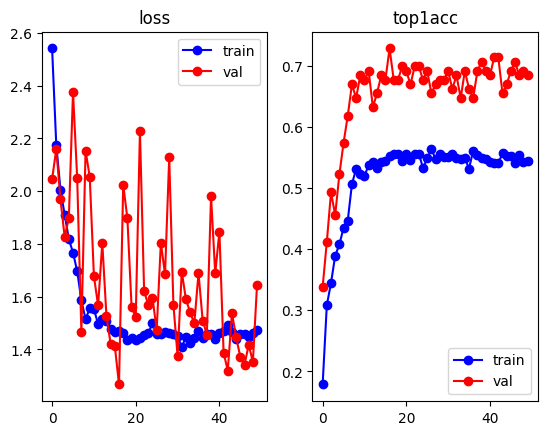

In [8]:
model_ft_3 = train_model(model_ft, criterion, optimizer_ft3, exp_lr_scheduler,
                       num_epochs=50)

## ConvNet as fixed feature extractor

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad = False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
[here](https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward)_.




In [11]:
model_conv = torchvision.models.densenet121(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.classifier.in_features
model_conv.classifier = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### Train and evaluate

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [12]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 2.1053 Acc: 0.3888
val Loss: 0.8972 Acc: 0.8382

Epoch 1/24
----------
train Loss: 1.2354 Acc: 0.6884
val Loss: 0.5643 Acc: 0.8676

Epoch 2/24
----------
train Loss: 0.9750 Acc: 0.7463
val Loss: 0.4006 Acc: 0.8750

Epoch 3/24
----------
train Loss: 0.7916 Acc: 0.7886
val Loss: 0.3916 Acc: 0.8971

Epoch 4/24
----------
train Loss: 0.7635 Acc: 0.7803
val Loss: 0.2907 Acc: 0.9191

Epoch 5/24
----------
train Loss: 0.7472 Acc: 0.7987
val Loss: 0.3201 Acc: 0.8971

Epoch 6/24
----------
train Loss: 0.6822 Acc: 0.8042
val Loss: 0.2356 Acc: 0.9265

Epoch 7/24
----------
train Loss: 0.5879 Acc: 0.8410
val Loss: 0.2452 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.5542 Acc: 0.8640
val Loss: 0.2257 Acc: 0.9338

Epoch 9/24
----------
train Loss: 0.6046 Acc: 0.8447
val Loss: 0.2500 Acc: 0.9485

Epoch 10/24
----------
train Loss: 0.5259 Acc: 0.8667
val Loss: 0.2258 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.5927 Acc: 0.8483
val Loss: 0.2521 Acc: 0.9338

Ep

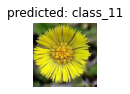

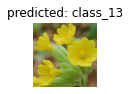

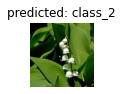

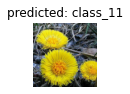

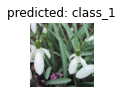

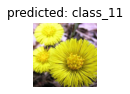

In [13]:
visualize_model(model_conv)

plt.ioff()
plt.show()

## Further Learning

If you would like to learn more about the applications of transfer learning,
checkout our [Quantized Transfer Learning for Computer Vision Tutorial](https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html).





In [ ]:
print(models.densenet121(pretrained=False))

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu